In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------
# Encoder with VAE heads
# --------------------------
class Encoder(nn.Module):
    def __init__(self, geo_feat_channels=128, z_down=True, padding_mode="replicate", latent_dim=128, kernel_size=(3, 3, 3), padding=(1, 1, 1)):
        super().__init__()
        self.z_down = z_down
        self.geo_feat_channels = geo_feat_channels

        self.conv0 = nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode)

        self.convblock1 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )

        if z_down:
            self.downsample1 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
            self.downsample2 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2,2,2), stride=(2,2,2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
        else:
            self.downsample1 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
            self.downsample2 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2,2,2), stride=(2,2,2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
        self.convblock2 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )
        self.to_mu = nn.Conv3d(geo_feat_channels, latent_dim, kernel_size=1)
        self.to_logvar = nn.Conv3d(geo_feat_channels, latent_dim, kernel_size=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # print(x.shape)
        x = self.conv0(x)
        x = x + self.convblock1(x)
        x = self.downsample1(x)  # [8,6,8]
        # print(x.shape)
        x = x + self.convblock2(x)
        x = self.downsample2(x)  # [4,3,4]
        # print(x.shape)
        x = x + self.convblock3(x)
        # print(x.shape)
        mu = self.to_mu(x)
        logvar = self.to_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


# --------------------------
# Decoder (symmetrical)
# --------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim=64, out_channels=31, padding_mode="replicate", kernel_size=(3, 3, 3), padding=(1, 1, 1)):
        super().__init__()

        self.conv0 = nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode)

        self.block1 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )

        self.upsample1 = nn.ConvTranspose3d(latent_dim, latent_dim, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose3d(latent_dim, latent_dim, kernel_size=2, stride=2)
        self.block2 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )
        self.block3 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )
        self.to_logits = nn.Conv3d(latent_dim, out_channels, kernel_size=1)

    def forward(self, z):  # z: [B, latent_dim, 4, 3, 4]
        x = self.conv0(z)
        x = x + self.block1(x)
        x = self.upsample1(x)  # [8,6,8]
        x = x + self.block2(x)
        x = self.upsample2(x)  # [16,12,16]
        x = x + self.block3(x)
        logits = self.to_logits(x)
        return logits

import torch
import torch.nn as nn
import torch.nn.functional as F

class VoxelVAE(nn.Module):
    def __init__(self, num_classes=31, embedding_dim=16,  latent_dim=64, padding_mode="replicate"):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_classes, embedding_dim)

        # Encoder
        self.encoder = Encoder(geo_feat_channels=embedding_dim, latent_dim=latent_dim, padding_mode=padding_mode)

        # Decoder
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=num_classes, padding_mode=padding_mode)

    def forward(self, label):  # label: [B, H, W, D], dtype: Long
        x = self.embedding(label).permute(0, 4, 1, 2, 3)  # [B, 8, H, W, D]
        z, mu, logvar = self.encoder(x)
        logits = self.decoder(z)
        return logits, mu, logvar

    def loss_function(self, logits, label, mu, logvar, beta=0.1):
        ce = F.cross_entropy(logits, label, reduction='mean')
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return ce + beta * kl, {'ce': ce.item(), 'kl': kl.item()}

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"💾 Saved model to {path}")

    def load(self, path, strict=True):
        self.load_state_dict(torch.load(path, map_location='cpu'), strict=strict)
        print(f"📥 Loaded model from {path}")


# 参数
B, H, W, D = 2, 16, 12, 16
device = "cuda" if torch.cuda.is_available() else "cpu"

# 模型初始化
model = VoxelVAE().to(device)

# 假数据
label = torch.randint(0, 31, (B, H, W, D)).to(device)

# 前向
logits, mu, logvar = model(label)

# 损失
loss, loss_dict = model.loss_function(logits, label, mu, logvar)
print("✅ Total loss:", loss.item())
print("  Breakdown:", loss_dict)
print(mu.shape)
# # 保存与加载
# model.save("voxelvae.pt")
# model.load("voxelvae.pt")



✅ Total loss: 3.658538818359375
  Breakdown: {'ce': 3.603740692138672, 'kl': 0.5479812622070312}
torch.Size([2, 64, 4, 3, 4])


In [6]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import torch

class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])  # shape: [16, 12, 16]
        
        # ✅ 四方向随机旋转（绕 y 轴，XZ 平面）
        k = np.random.randint(0, 4)  # 0, 1, 2, 3
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()  # (x, z) 旋转
        
        return torch.tensor(voxel, dtype=torch.long)


# ---------- Training Loop ----------
from tqdm import tqdm

def train_voxelvae():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️ Device: {device}")

    model = VoxelVAE().to(device)
    dataset = VoxelPatchDataset("dataset")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # ✅ Exponential decay: 1e-3 → 1e-5 over 30 epochs
    gamma = (1e-5 / 1e-3) ** (1 / 29)  # decay every epoch
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    for epoch in range(1, 31):  # ← 30 epochs
        model.train()
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"🌀 Epoch {epoch}", dynamic_ncols=True)

        for batch in pbar:
            batch = batch.to(device)
            logits, mu, logvar = model(batch)
            loss, loss_dict = model.loss_function(logits, batch, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), ce=loss_dict["ce"], kl=loss_dict["kl"])

        scheduler.step()  # ✅ update learning rate
        print(f"📦 Epoch {epoch} | Total Loss: {total_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")
        model.save(f"voxelvae_epoch{epoch}.pt")

if __name__ == "__main__":
    train_voxelvae()


🖥️ Device: cuda


🌀 Epoch 1: 100%|██████████| 5052/5052 [01:41<00:00, 50.02it/s, ce=0.11, kl=0.212, loss=0.131]   


📦 Epoch 1 | Total Loss: 1196.8075 | LR: 8.53e-04
💾 Saved model to voxelvae_epoch1.pt


🌀 Epoch 2: 100%|██████████| 5052/5052 [01:40<00:00, 50.25it/s, ce=0.0685, kl=0.194, loss=0.0879]


📦 Epoch 2 | Total Loss: 545.6485 | LR: 7.28e-04
💾 Saved model to voxelvae_epoch2.pt


🌀 Epoch 3: 100%|██████████| 5052/5052 [01:40<00:00, 50.36it/s, ce=0.0236, kl=0.166, loss=0.0401]


📦 Epoch 3 | Total Loss: 395.6749 | LR: 6.21e-04
💾 Saved model to voxelvae_epoch3.pt


🌀 Epoch 4: 100%|██████████| 5052/5052 [01:40<00:00, 50.03it/s, ce=0.0426, kl=0.174, loss=0.06]  


📦 Epoch 4 | Total Loss: 326.9228 | LR: 5.30e-04
💾 Saved model to voxelvae_epoch4.pt


🌀 Epoch 5: 100%|██████████| 5052/5052 [01:40<00:00, 50.31it/s, ce=0.0257, kl=0.179, loss=0.0436]


📦 Epoch 5 | Total Loss: 309.6562 | LR: 4.52e-04
💾 Saved model to voxelvae_epoch5.pt


🌀 Epoch 6: 100%|██████████| 5052/5052 [01:40<00:00, 50.13it/s, ce=0.041, kl=0.178, loss=0.0589] 


📦 Epoch 6 | Total Loss: 265.5987 | LR: 3.86e-04
💾 Saved model to voxelvae_epoch6.pt


🌀 Epoch 7: 100%|██████████| 5052/5052 [01:40<00:00, 50.09it/s, ce=0.0341, kl=0.178, loss=0.0519]


📦 Epoch 7 | Total Loss: 242.0060 | LR: 3.29e-04
💾 Saved model to voxelvae_epoch7.pt


🌀 Epoch 8: 100%|██████████| 5052/5052 [01:40<00:00, 50.16it/s, ce=0.0279, kl=0.168, loss=0.0448]


📦 Epoch 8 | Total Loss: 227.2128 | LR: 2.81e-04
💾 Saved model to voxelvae_epoch8.pt


🌀 Epoch 9: 100%|██████████| 5052/5052 [01:41<00:00, 49.97it/s, ce=0.0207, kl=0.156, loss=0.0363]


📦 Epoch 9 | Total Loss: 212.5628 | LR: 2.40e-04
💾 Saved model to voxelvae_epoch9.pt


🌀 Epoch 10: 100%|██████████| 5052/5052 [01:41<00:00, 49.91it/s, ce=0.0173, kl=0.168, loss=0.0341]


📦 Epoch 10 | Total Loss: 205.2008 | LR: 2.04e-04
💾 Saved model to voxelvae_epoch10.pt


🌀 Epoch 11: 100%|██████████| 5052/5052 [01:40<00:00, 50.06it/s, ce=0.0174, kl=0.154, loss=0.0328] 


📦 Epoch 11 | Total Loss: 195.3427 | LR: 1.74e-04
💾 Saved model to voxelvae_epoch11.pt


🌀 Epoch 12: 100%|██████████| 5052/5052 [01:48<00:00, 46.71it/s, ce=0.016, kl=0.155, loss=0.0316]  


📦 Epoch 12 | Total Loss: 189.1357 | LR: 1.49e-04
💾 Saved model to voxelvae_epoch12.pt


🌀 Epoch 13: 100%|██████████| 5052/5052 [02:27<00:00, 34.30it/s, ce=0.0286, kl=0.156, loss=0.0442] 


📦 Epoch 13 | Total Loss: 182.2540 | LR: 1.27e-04
💾 Saved model to voxelvae_epoch13.pt


🌀 Epoch 14: 100%|██████████| 5052/5052 [02:29<00:00, 33.70it/s, ce=0.0128, kl=0.159, loss=0.0287] 


📦 Epoch 14 | Total Loss: 177.9775 | LR: 1.08e-04
💾 Saved model to voxelvae_epoch14.pt


🌀 Epoch 15: 100%|██████████| 5052/5052 [02:23<00:00, 35.16it/s, ce=0.0305, kl=0.161, loss=0.0467] 


📦 Epoch 15 | Total Loss: 174.1890 | LR: 9.24e-05
💾 Saved model to voxelvae_epoch15.pt


🌀 Epoch 16: 100%|██████████| 5052/5052 [02:39<00:00, 31.68it/s, ce=0.0123, kl=0.157, loss=0.0279] 


📦 Epoch 16 | Total Loss: 170.7652 | LR: 7.88e-05
💾 Saved model to voxelvae_epoch16.pt


🌀 Epoch 17: 100%|██████████| 5052/5052 [02:33<00:00, 32.97it/s, ce=0.0115, kl=0.168, loss=0.0283] 


📦 Epoch 17 | Total Loss: 167.6607 | LR: 6.72e-05
💾 Saved model to voxelvae_epoch17.pt


🌀 Epoch 18: 100%|██████████| 5052/5052 [02:35<00:00, 32.56it/s, ce=0.0166, kl=0.158, loss=0.0324] 


📦 Epoch 18 | Total Loss: 165.0115 | LR: 5.74e-05
💾 Saved model to voxelvae_epoch18.pt


🌀 Epoch 19: 100%|██████████| 5052/5052 [02:36<00:00, 32.20it/s, ce=0.0208, kl=0.157, loss=0.0365] 


📦 Epoch 19 | Total Loss: 162.8307 | LR: 4.89e-05
💾 Saved model to voxelvae_epoch19.pt


🌀 Epoch 20: 100%|██████████| 5052/5052 [02:31<00:00, 33.38it/s, ce=0.0277, kl=0.165, loss=0.0442] 


📦 Epoch 20 | Total Loss: 161.4358 | LR: 4.18e-05
💾 Saved model to voxelvae_epoch20.pt


🌀 Epoch 21: 100%|██████████| 5052/5052 [02:31<00:00, 33.25it/s, ce=0.0124, kl=0.154, loss=0.0279] 


📦 Epoch 21 | Total Loss: 160.0435 | LR: 3.56e-05
💾 Saved model to voxelvae_epoch21.pt


🌀 Epoch 22: 100%|██████████| 5052/5052 [02:36<00:00, 32.37it/s, ce=0.00933, kl=0.15, loss=0.0244] 


📦 Epoch 22 | Total Loss: 158.9257 | LR: 3.04e-05
💾 Saved model to voxelvae_epoch22.pt


🌀 Epoch 23: 100%|██████████| 5052/5052 [02:30<00:00, 33.51it/s, ce=0.0109, kl=0.151, loss=0.026]  


📦 Epoch 23 | Total Loss: 157.9707 | LR: 2.59e-05
💾 Saved model to voxelvae_epoch23.pt


🌀 Epoch 24: 100%|██████████| 5052/5052 [02:34<00:00, 32.66it/s, ce=0.014, kl=0.156, loss=0.0296]  


📦 Epoch 24 | Total Loss: 157.2849 | LR: 2.21e-05
💾 Saved model to voxelvae_epoch24.pt


🌀 Epoch 25: 100%|██████████| 5052/5052 [02:33<00:00, 32.87it/s, ce=0.012, kl=0.145, loss=0.0265]  


📦 Epoch 25 | Total Loss: 156.5036 | LR: 1.89e-05
💾 Saved model to voxelvae_epoch25.pt


🌀 Epoch 26: 100%|██████████| 5052/5052 [01:50<00:00, 45.81it/s, ce=0.00939, kl=0.15, loss=0.0243] 


📦 Epoch 26 | Total Loss: 155.9806 | LR: 1.61e-05
💾 Saved model to voxelvae_epoch26.pt


🌀 Epoch 27: 100%|██████████| 5052/5052 [01:40<00:00, 50.49it/s, ce=0.0109, kl=0.145, loss=0.0255] 


📦 Epoch 27 | Total Loss: 155.3269 | LR: 1.37e-05
💾 Saved model to voxelvae_epoch27.pt


🌀 Epoch 28: 100%|██████████| 5052/5052 [01:40<00:00, 50.47it/s, ce=0.015, kl=0.162, loss=0.0312]  


📦 Epoch 28 | Total Loss: 154.9010 | LR: 1.17e-05
💾 Saved model to voxelvae_epoch28.pt


🌀 Epoch 29: 100%|██████████| 5052/5052 [01:40<00:00, 50.51it/s, ce=0.0144, kl=0.148, loss=0.0291] 


📦 Epoch 29 | Total Loss: 154.3828 | LR: 1.00e-05
💾 Saved model to voxelvae_epoch29.pt


🌀 Epoch 30: 100%|██████████| 5052/5052 [01:39<00:00, 50.59it/s, ce=0.00679, kl=0.147, loss=0.0215]

📦 Epoch 30 | Total Loss: 154.2665 | LR: 8.53e-06
💾 Saved model to voxelvae_epoch30.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2189406302.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'),

📥 Loaded model from voxelvae_64_434.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\984858117.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20b", 31)


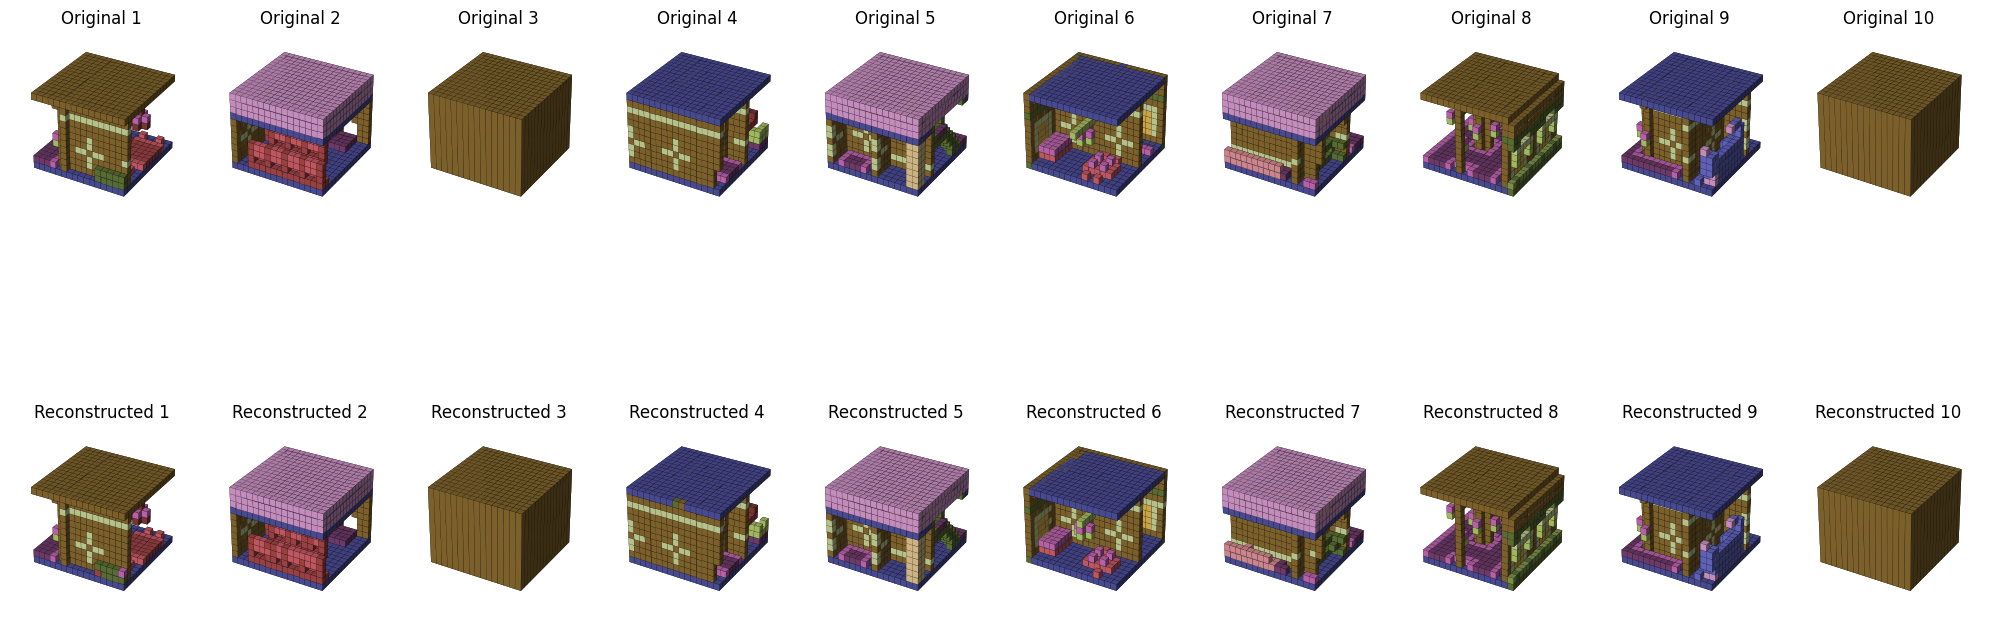

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoxelVAE().to(device)
model.load("voxelvae_64_434.pt")
model.eval()

# Load label-to-name map
label_to_name = [
    'minecraft:air', 'minecraft:birch_leaves', 'minecraft:birch_planks', 'minecraft:birch_stairs',
    'minecraft:black_wool', 'minecraft:bookshelf', 'minecraft:cobblestone', 'minecraft:cobblestone_stairs',
    'minecraft:cobblestone_wall', 'minecraft:dark_oak_fence', 'minecraft:dark_oak_leaves',
    'minecraft:dark_oak_log', 'minecraft:dark_oak_planks', 'minecraft:dark_oak_stairs', 'minecraft:dirt',
    'minecraft:glass_pane', 'minecraft:grass_block', 'minecraft:light_gray_wool', 'minecraft:oak_fence',
    'minecraft:oak_leaves', 'minecraft:oak_planks', 'minecraft:oak_slab', 'minecraft:oak_stairs',
    'minecraft:polished_andesite', 'minecraft:red_carpet', 'minecraft:smooth_stone_slab', 'minecraft:stone',
    'minecraft:torch', 'minecraft:white_carpet', 'minecraft:white_wool', 'minecraft:air'  # for unknown
]

# Randomly pick 10 patches
patch_paths = list(Path("dataset").rglob("patch_*.npy"))
chosen_paths = np.random.choice(patch_paths, 10, replace=False)

# Visualize before and after for each
def visualize_voxel_patch(ax, voxel, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    voxel = np.transpose(voxel, (0, 2, 1))  # XZY
    mask = (voxel != 0)
    facecolors = cmap(voxel % 31)
    facecolors[~mask] = [0, 0, 0, 0]
    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')

fig = plt.figure(figsize=(20, 10))
for i, path in enumerate(chosen_paths):
    patch = np.load(path)
    input_tensor = torch.tensor(patch, dtype=torch.long).unsqueeze(0).to(device)  # [1, H, W, D]
    with torch.no_grad():
        recon_logits, _, _ = model(input_tensor)
        recon_label = recon_logits.argmax(dim=1).squeeze(0).cpu().numpy()

    ax1 = fig.add_subplot(2, 10, i + 1, projection='3d')
    visualize_voxel_patch(ax1, patch, f"Original {i+1}")

    ax2 = fig.add_subplot(2, 10, i + 11, projection='3d')
    visualize_voxel_patch(ax2, recon_label, f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
from tqdm import tqdm

# --------- Dataset ---------
class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])
        k = np.random.randint(0, 4)
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()
        return torch.tensor(voxel, dtype=torch.long)

# --------- Training ---------
def train_voxelvae(start_epoch=43, resume_path="voxelvae_epoch52.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Device: {device}")

    model = VoxelVAE().to(device)

    if Path(resume_path).exists():
        print(f"📂 Loading model from {resume_path}")
        model.load(resume_path)

    dataset = VoxelPatchDataset("dataset")
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

    optimizer = optim.Adam(model.parameters(), lr=2e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-7)

    for epoch in range(start_epoch, start_epoch + 10):
        model.train()
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"🌀 Epoch {epoch}", dynamic_ncols=True)

        for batch in pbar:
            batch = batch.to(device)
            logits, mu, logvar = model(batch)
            loss, loss_dict = model.loss_function(logits, batch, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), ce=loss_dict["ce"], kl=loss_dict["kl"])

        scheduler.step()
        print(f"📦 Epoch {epoch} | Total Loss: {total_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")
        model.save(f"voxelvae_epoch{epoch}.pt")

if __name__ == "__main__":
    train_voxelvae()


🚀 Device: cuda
📂 Loading model from voxelvae_epoch52.pt
📥 Loaded model from voxelvae_epoch52.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2189406302.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'),

KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------------------
# Encoder with VAE heads
# --------------------------
class Encoder(nn.Module):
    def __init__(self, geo_feat_channels=128, z_down=True, padding_mode="replicate", latent_dim=128, kernel_size=(3, 3, 3), padding=(1, 1, 1)):
        super().__init__()
        self.z_down = z_down
        self.geo_feat_channels = geo_feat_channels

        self.conv0 = nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode)

        self.convblock1 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )

        if z_down:
            self.downsample1 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
            # self.downsample2 = nn.Sequential(
            #     nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2,2,2), stride=(2,2,2), padding=0, padding_mode=padding_mode),
            #     nn.InstanceNorm3d(geo_feat_channels)
            # )
        else:
            self.downsample1 = nn.Sequential(
                nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0, padding_mode=padding_mode),
                nn.InstanceNorm3d(geo_feat_channels)
            )
            # self.downsample2 = nn.Sequential(
            #     nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=(2,2,2), stride=(2,2,2), padding=0, padding_mode=padding_mode),
            #     nn.InstanceNorm3d(geo_feat_channels)
            # )
        self.convblock2 = nn.Sequential(
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(geo_feat_channels)
        )
        # self.convblock3 = nn.Sequential(
        #     nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
        #     nn.InstanceNorm3d(geo_feat_channels),
        #     nn.LeakyReLU(1e-1, True),
        #     nn.Conv3d(geo_feat_channels, geo_feat_channels, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
        #     nn.InstanceNorm3d(geo_feat_channels)
        # )
        self.to_mu = nn.Conv3d(geo_feat_channels, latent_dim, kernel_size=1)
        self.to_logvar = nn.Conv3d(geo_feat_channels, latent_dim, kernel_size=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # print(x.shape)
        x = self.conv0(x)
        x = x + self.convblock1(x)
        x = self.downsample1(x)  # [8,6,8]
        # print(x.shape)
        x = x + self.convblock2(x)
        # x = self.downsample2(x)  # [4,3,4]
        # print(x.shape)
        # x = x + self.convblock3(x)
        # print(x.shape)
        mu = self.to_mu(x)
        logvar = self.to_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar


# --------------------------
# Decoder (symmetrical)
# --------------------------
class Decoder(nn.Module):
    def __init__(self, latent_dim=64, out_channels=31, padding_mode="replicate", kernel_size=(3, 3, 3), padding=(1, 1, 1)):
        super().__init__()

        self.conv0 = nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode)

        self.block1 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )

        self.upsample1 = nn.ConvTranspose3d(latent_dim, latent_dim, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose3d(latent_dim, latent_dim, kernel_size=2, stride=2)
        self.block2 = nn.Sequential(
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim),
            nn.LeakyReLU(1e-1, True),
            nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
            nn.InstanceNorm3d(latent_dim)
        )
        # self.block3 = nn.Sequential(
        #     nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
        #     nn.InstanceNorm3d(latent_dim),
        #     nn.LeakyReLU(1e-1, True),
        #     nn.Conv3d(latent_dim, latent_dim, kernel_size=kernel_size, padding=padding, padding_mode=padding_mode),
        #     nn.InstanceNorm3d(latent_dim)
        # )
        self.to_logits = nn.Conv3d(latent_dim, out_channels, kernel_size=1)

    def forward(self, z):  # z: [B, latent_dim, 4, 3, 4]
        x = self.conv0(z)
        x = x + self.block1(x)
        x = self.upsample1(x)  # [8,6,8]
        x = x + self.block2(x)
        # x = self.upsample2(x)  # [16,12,16]
        # x = x + self.block3(x)
        logits = self.to_logits(x)
        return logits

import torch
import torch.nn as nn
import torch.nn.functional as F

class VoxelVAE(nn.Module):
    def __init__(self, num_classes=31, embedding_dim=16,  latent_dim=32, padding_mode="replicate"):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_classes, embedding_dim)

        # Encoder
        self.encoder = Encoder(geo_feat_channels=embedding_dim, latent_dim=latent_dim, padding_mode=padding_mode)

        # Decoder
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=num_classes, padding_mode=padding_mode)

    def forward(self, label):  # label: [B, H, W, D], dtype: Long
        x = self.embedding(label).permute(0, 4, 1, 2, 3)  # [B, 8, H, W, D]
        z, mu, logvar = self.encoder(x)
        logits = self.decoder(z)
        return logits, mu, logvar

    def loss_function(self, logits, label, mu, logvar, beta=0.1):
        ce = F.cross_entropy(logits, label, reduction='mean')
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return ce + beta * kl, {'ce': ce.item(), 'kl': kl.item()}

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"💾 Saved model to {path}")

    def load(self, path, strict=True):
        self.load_state_dict(torch.load(path, map_location='cpu'), strict=strict)
        print(f"📥 Loaded model from {path}")


# 参数
B, H, W, D = 2, 16, 12, 16
device = "cuda" if torch.cuda.is_available() else "cpu"

# 模型初始化
model = VoxelVAE().to(device)

# 假数据
label = torch.randint(0, 31, (B, H, W, D)).to(device)

# 前向
logits, mu, logvar = model(label)

# 损失
loss, loss_dict = model.loss_function(logits, label, mu, logvar)
print("✅ Total loss:", loss.item())
print("  Breakdown:", loss_dict)
print(mu.shape)
# # 保存与加载
# model.save("voxelvae.pt")
# model.load("voxelvae.pt")



✅ Total loss: 3.672454595565796
  Breakdown: {'ce': 3.6134684085845947, 'kl': 0.5898609161376953}
torch.Size([2, 32, 8, 6, 8])


In [25]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import torch

class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])  # shape: [16, 12, 16]
        
        # ✅ 四方向随机旋转（绕 y 轴，XZ 平面）
        k = np.random.randint(0, 4)  # 0, 1, 2, 3
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()  # (x, z) 旋转
        
        return torch.tensor(voxel, dtype=torch.long)


# ---------- Training Loop ----------
from tqdm import tqdm

def train_voxelvae():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = VoxelVAE().to(device)
    dataset = VoxelPatchDataset("dataset")
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, 21):
        model.train()
        total_loss = 0

        # ✅ tqdm 进度条
        pbar = tqdm(dataloader, desc=f"🌀 Epoch {epoch}", dynamic_ncols=True)

        for batch in pbar:
            # print("Loaded batch:", batch.shape)
            batch = batch.to(device)
            logits, mu, logvar = model(batch)
            loss, loss_dict = model.loss_function(logits, batch, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), ce=loss_dict["ce"], kl=loss_dict["kl"])

        print(f"📦 Epoch {epoch} | Total Loss: {total_loss:.4f}")
        model.save(f"voxelvae_epoch{epoch}.pt")

if __name__ == "__main__":
    train_voxelvae()


cuda


🌀 Epoch 1: 100%|██████████| 5052/5052 [01:34<00:00, 53.22it/s, ce=0.0494, kl=0.228, loss=0.0722]


📦 Epoch 1 | Total Loss: 648.1235
💾 Saved model to voxelvae_epoch1.pt


🌀 Epoch 2: 100%|██████████| 5052/5052 [01:50<00:00, 45.56it/s, ce=0.0367, kl=0.219, loss=0.0586]


📦 Epoch 2 | Total Loss: 287.8795
💾 Saved model to voxelvae_epoch2.pt


🌀 Epoch 3: 100%|██████████| 5052/5052 [02:00<00:00, 41.99it/s, ce=0.0367, kl=0.206, loss=0.0572] 


📦 Epoch 3 | Total Loss: 243.3096
💾 Saved model to voxelvae_epoch3.pt


🌀 Epoch 4: 100%|██████████| 5052/5052 [02:01<00:00, 41.57it/s, ce=0.0131, kl=0.179, loss=0.031]  


📦 Epoch 4 | Total Loss: 227.2392
💾 Saved model to voxelvae_epoch4.pt


🌀 Epoch 5: 100%|██████████| 5052/5052 [01:46<00:00, 47.49it/s, ce=0.0173, kl=0.176, loss=0.0348] 


📦 Epoch 5 | Total Loss: 202.4503
💾 Saved model to voxelvae_epoch5.pt


🌀 Epoch 6: 100%|██████████| 5052/5052 [01:16<00:00, 66.32it/s, ce=0.0237, kl=0.16, loss=0.0397]  


📦 Epoch 6 | Total Loss: 184.3572
💾 Saved model to voxelvae_epoch6.pt


🌀 Epoch 7: 100%|██████████| 5052/5052 [02:01<00:00, 41.70it/s, ce=0.0188, kl=0.174, loss=0.0362] 


📦 Epoch 7 | Total Loss: 178.7301
💾 Saved model to voxelvae_epoch7.pt


🌀 Epoch 8: 100%|██████████| 5052/5052 [02:04<00:00, 40.73it/s, ce=0.0231, kl=0.173, loss=0.0404] 


📦 Epoch 8 | Total Loss: 168.4543
💾 Saved model to voxelvae_epoch8.pt


🌀 Epoch 9: 100%|██████████| 5052/5052 [01:49<00:00, 46.22it/s, ce=0.114, kl=0.155, loss=0.129]   


📦 Epoch 9 | Total Loss: 165.5743
💾 Saved model to voxelvae_epoch9.pt


🌀 Epoch 10: 100%|██████████| 5052/5052 [01:47<00:00, 46.84it/s, ce=0.0264, kl=0.187, loss=0.0451] 


📦 Epoch 10 | Total Loss: 180.7979
💾 Saved model to voxelvae_epoch10.pt


🌀 Epoch 11: 100%|██████████| 5052/5052 [02:01<00:00, 41.52it/s, ce=0.00964, kl=0.157, loss=0.0254]


📦 Epoch 11 | Total Loss: 164.8825
💾 Saved model to voxelvae_epoch11.pt


🌀 Epoch 12: 100%|██████████| 5052/5052 [02:03<00:00, 40.93it/s, ce=0.0141, kl=0.16, loss=0.0301]  


📦 Epoch 12 | Total Loss: 163.9804
💾 Saved model to voxelvae_epoch12.pt


🌀 Epoch 13: 100%|██████████| 5052/5052 [02:00<00:00, 41.90it/s, ce=0.0108, kl=0.151, loss=0.0259] 


📦 Epoch 13 | Total Loss: 165.2443
💾 Saved model to voxelvae_epoch13.pt


🌀 Epoch 14: 100%|██████████| 5052/5052 [02:03<00:00, 40.88it/s, ce=0.00979, kl=0.143, loss=0.0241]


📦 Epoch 14 | Total Loss: 156.4773
💾 Saved model to voxelvae_epoch14.pt


🌀 Epoch 15: 100%|██████████| 5052/5052 [01:59<00:00, 42.20it/s, ce=0.0109, kl=0.157, loss=0.0266] 


📦 Epoch 15 | Total Loss: 149.5120
💾 Saved model to voxelvae_epoch15.pt


🌀 Epoch 16: 100%|██████████| 5052/5052 [02:02<00:00, 41.34it/s, ce=0.00906, kl=0.157, loss=0.0248]


📦 Epoch 16 | Total Loss: 145.9622
💾 Saved model to voxelvae_epoch16.pt


🌀 Epoch 17: 100%|██████████| 5052/5052 [02:00<00:00, 41.95it/s, ce=0.0115, kl=0.157, loss=0.0273] 


📦 Epoch 17 | Total Loss: 147.8869
💾 Saved model to voxelvae_epoch17.pt


🌀 Epoch 18: 100%|██████████| 5052/5052 [02:05<00:00, 40.22it/s, ce=0.0119, kl=0.151, loss=0.027]  


📦 Epoch 18 | Total Loss: 147.1349
💾 Saved model to voxelvae_epoch18.pt


🌀 Epoch 19: 100%|██████████| 5052/5052 [02:02<00:00, 41.08it/s, ce=0.0107, kl=0.152, loss=0.0259] 


📦 Epoch 19 | Total Loss: 143.1611
💾 Saved model to voxelvae_epoch19.pt


🌀 Epoch 20: 100%|██████████| 5052/5052 [02:03<00:00, 40.98it/s, ce=0.0132, kl=0.159, loss=0.0291] 

📦 Epoch 20 | Total Loss: 142.8285
💾 Saved model to voxelvae_epoch20.pt


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoxelVAE().to(device)
model.load("voxelvae_epoch20.pt")
model.eval()

# Load label-to-name map
label_to_name = [
    'minecraft:air', 'minecraft:birch_leaves', 'minecraft:birch_planks', 'minecraft:birch_stairs',
    'minecraft:black_wool', 'minecraft:bookshelf', 'minecraft:cobblestone', 'minecraft:cobblestone_stairs',
    'minecraft:cobblestone_wall', 'minecraft:dark_oak_fence', 'minecraft:dark_oak_leaves',
    'minecraft:dark_oak_log', 'minecraft:dark_oak_planks', 'minecraft:dark_oak_stairs', 'minecraft:dirt',
    'minecraft:glass_pane', 'minecraft:grass_block', 'minecraft:light_gray_wool', 'minecraft:oak_fence',
    'minecraft:oak_leaves', 'minecraft:oak_planks', 'minecraft:oak_slab', 'minecraft:oak_stairs',
    'minecraft:polished_andesite', 'minecraft:red_carpet', 'minecraft:smooth_stone_slab', 'minecraft:stone',
    'minecraft:torch', 'minecraft:white_carpet', 'minecraft:white_wool', 'minecraft:air'  # for unknown
]

# Randomly pick 10 patches
patch_paths = list(Path("dataset").rglob("patch_*.npy"))
chosen_paths = np.random.choice(patch_paths, 10, replace=False)

# Visualize before and after for each
def visualize_voxel_patch(ax, voxel, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    voxel = np.transpose(voxel, (0, 2, 1))  # XZY
    mask = (voxel != 0)
    facecolors = cmap(voxel % 31)
    facecolors[~mask] = [0, 0, 0, 0]
    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')

fig = plt.figure(figsize=(20, 10))
for i, path in enumerate(chosen_paths):
    patch = np.load(path)
    input_tensor = torch.tensor(patch, dtype=torch.long).unsqueeze(0).to(device)  # [1, H, W, D]
    with torch.no_grad():
        recon_logits, _, _ = model(input_tensor)
        recon_label = recon_logits.argmax(dim=1).squeeze(0).cpu().numpy()

    ax1 = fig.add_subplot(2, 10, i + 1, projection='3d')
    visualize_voxel_patch(ax1, patch, f"Original {i+1}")

    ax2 = fig.add_subplot(2, 10, i + 11, projection='3d')
    visualize_voxel_patch(ax2, recon_label, f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


NameError: name 'VoxelVAE' is not defined

In [13]:
import torch
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
class VoxelPatchDataset(Dataset):
    def __init__(self, root_dir):
        self.paths = list(Path(root_dir).rglob("patch_*.npy"))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        voxel = np.load(self.paths[idx])  # shape: [16, 12, 16]
        
        # ✅ 四方向随机旋转（绕 y 轴，XZ 平面）
        k = np.random.randint(0, 4)  # 0, 1, 2, 3
        voxel = np.rot90(voxel, k=k, axes=(0, 2)).copy()  # (x, z) 旋转
        
        return torch.tensor(voxel, dtype=torch.long)
def train_voxelvae(start_epoch=24, resume_path="voxelvae_epoch24.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Device: {device}")

    model = VoxelVAE().to(device)

    # ✅ 加载已有模型
    if Path(resume_path).exists():
        print(f"📂 Loading model from {resume_path}")
        model.load(resume_path)

    dataset = VoxelPatchDataset("dataset")
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    for epoch in range(start_epoch, start_epoch + 10):
        model.train()
        total_loss = 0

        pbar = tqdm(dataloader, desc=f"🌀 Epoch {epoch}", dynamic_ncols=True)

        for batch in pbar:
            batch = batch.to(device)
            logits, mu, logvar = model(batch)
            loss, loss_dict = model.loss_function(logits, batch, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), ce=loss_dict["ce"], kl=loss_dict["kl"])

        print(f"📦 Epoch {epoch} | Total Loss: {total_loss:.4f}")
        model.save(f"voxelvae_epoch{epoch}.pt")

if __name__ == "__main__":
    train_voxelvae()


🚀 Device: cuda
📂 Loading model from voxelvae_epoch24.pt
📥 Loaded model from voxelvae_epoch24.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21636\140569341.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'), 

📦 Epoch 24 | Total Loss: 55.7673
💾 Saved model to voxelvae_epoch24.pt


🌀 Epoch 25: 100%|██████████| 2526/2526 [01:27<00:00, 28.94it/s, ce=0.00645, kl=0.138, loss=0.0202]


📦 Epoch 25 | Total Loss: 55.6268
💾 Saved model to voxelvae_epoch25.pt


🌀 Epoch 26: 100%|██████████| 2526/2526 [01:29<00:00, 28.18it/s, ce=0.00576, kl=0.137, loss=0.0194]


📦 Epoch 26 | Total Loss: 55.5817
💾 Saved model to voxelvae_epoch26.pt


🌀 Epoch 27: 100%|██████████| 2526/2526 [01:36<00:00, 26.17it/s, ce=0.0188, kl=0.146, loss=0.0333] 


📦 Epoch 27 | Total Loss: 55.5140
💾 Saved model to voxelvae_epoch27.pt


🌀 Epoch 28: 100%|██████████| 2526/2526 [01:36<00:00, 26.28it/s, ce=0.00781, kl=0.134, loss=0.0212]


📦 Epoch 28 | Total Loss: 55.4585
💾 Saved model to voxelvae_epoch28.pt


🌀 Epoch 29: 100%|██████████| 2526/2526 [01:36<00:00, 26.27it/s, ce=0.00574, kl=0.13, loss=0.0188] 


📦 Epoch 29 | Total Loss: 55.4127
💾 Saved model to voxelvae_epoch29.pt


🌀 Epoch 30: 100%|██████████| 2526/2526 [01:23<00:00, 30.14it/s, ce=0.00992, kl=0.136, loss=0.0236]


📦 Epoch 30 | Total Loss: 55.3606
💾 Saved model to voxelvae_epoch30.pt


🌀 Epoch 31: 100%|██████████| 2526/2526 [01:32<00:00, 27.31it/s, ce=0.00752, kl=0.139, loss=0.0214]


📦 Epoch 31 | Total Loss: 55.2957
💾 Saved model to voxelvae_epoch31.pt


🌀 Epoch 32: 100%|██████████| 2526/2526 [01:37<00:00, 26.00it/s, ce=0.0099, kl=0.142, loss=0.0241] 


📦 Epoch 32 | Total Loss: 55.3090
💾 Saved model to voxelvae_epoch32.pt


🌀 Epoch 33: 100%|██████████| 2526/2526 [01:35<00:00, 26.53it/s, ce=0.00743, kl=0.131, loss=0.0206]


📦 Epoch 33 | Total Loss: 55.2693
💾 Saved model to voxelvae_epoch33.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21636\140569341.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'), 

📥 Loaded model from voxelvae_epoch33.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21636\318924246.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20b", 31)


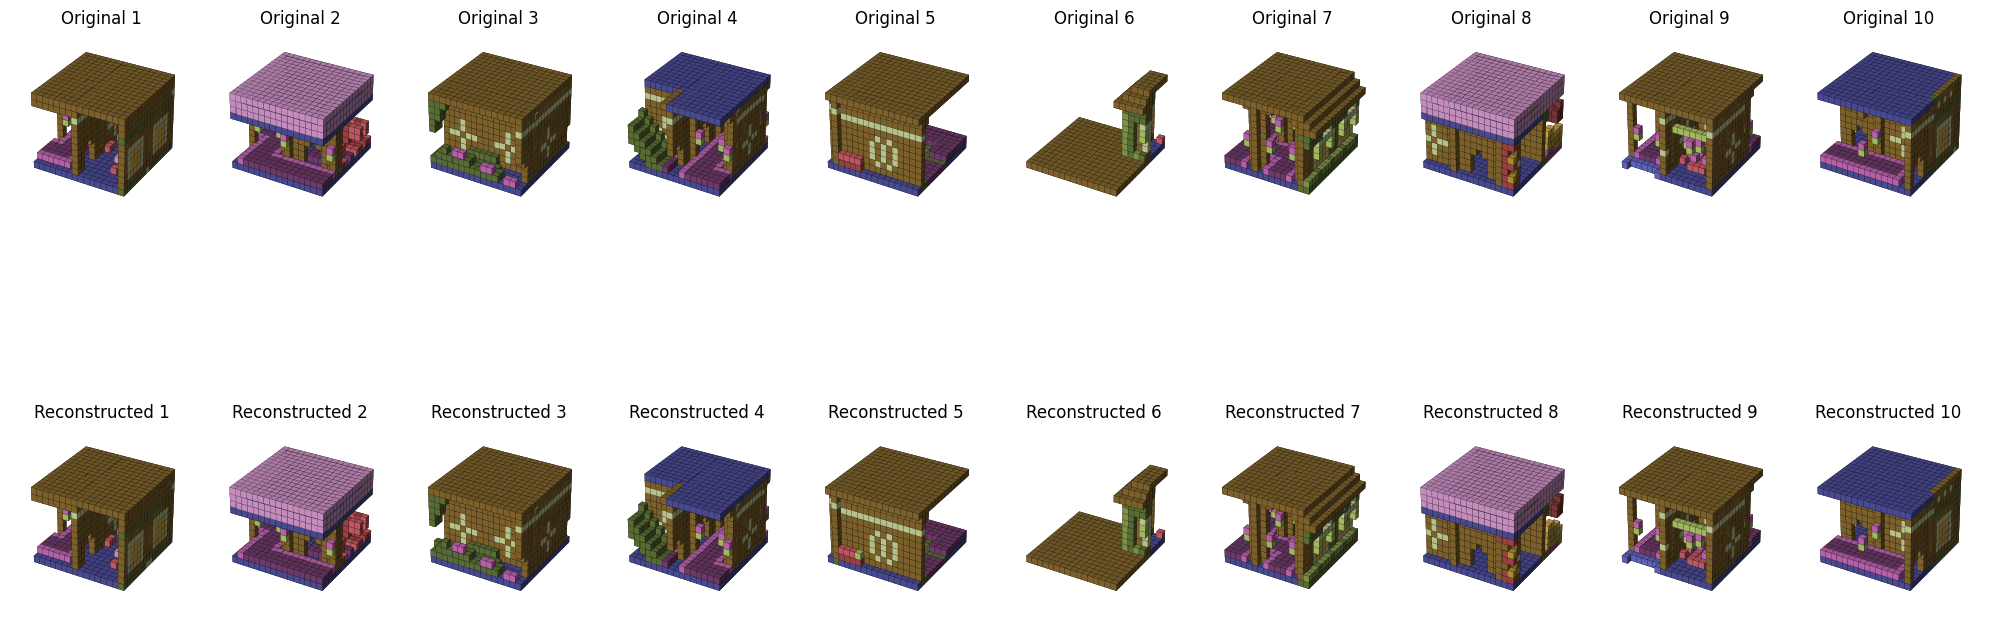

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoxelVAE().to(device)
model.load("voxelvae_epoch33.pt")
model.eval()

# Load label-to-name map
label_to_name = [
    'minecraft:air', 'minecraft:birch_leaves', 'minecraft:birch_planks', 'minecraft:birch_stairs',
    'minecraft:black_wool', 'minecraft:bookshelf', 'minecraft:cobblestone', 'minecraft:cobblestone_stairs',
    'minecraft:cobblestone_wall', 'minecraft:dark_oak_fence', 'minecraft:dark_oak_leaves',
    'minecraft:dark_oak_log', 'minecraft:dark_oak_planks', 'minecraft:dark_oak_stairs', 'minecraft:dirt',
    'minecraft:glass_pane', 'minecraft:grass_block', 'minecraft:light_gray_wool', 'minecraft:oak_fence',
    'minecraft:oak_leaves', 'minecraft:oak_planks', 'minecraft:oak_slab', 'minecraft:oak_stairs',
    'minecraft:polished_andesite', 'minecraft:red_carpet', 'minecraft:smooth_stone_slab', 'minecraft:stone',
    'minecraft:torch', 'minecraft:white_carpet', 'minecraft:white_wool', 'minecraft:air'  # for unknown
]

# Randomly pick 10 patches
patch_paths = list(Path("dataset").rglob("patch_*.npy"))
chosen_paths = np.random.choice(patch_paths, 10, replace=False)

# Visualize before and after for each
def visualize_voxel_patch(ax, voxel, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    voxel = np.transpose(voxel, (0, 2, 1))  # XZY
    mask = (voxel != 0)
    facecolors = cmap(voxel % 31)
    facecolors[~mask] = [0, 0, 0, 0]
    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title)
    ax.axis('off')

fig = plt.figure(figsize=(20, 10))
for i, path in enumerate(chosen_paths):
    patch = np.load(path)
    input_tensor = torch.tensor(patch, dtype=torch.long).unsqueeze(0).to(device)  # [1, H, W, D]
    with torch.no_grad():
        recon_logits, _, _ = model(input_tensor)
        recon_label = recon_logits.argmax(dim=1).squeeze(0).cpu().numpy()

    ax1 = fig.add_subplot(2, 10, i + 1, projection='3d')
    visualize_voxel_patch(ax1, patch, f"Original {i+1}")

    ax2 = fig.add_subplot(2, 10, i + 11, projection='3d')
    visualize_voxel_patch(ax2, recon_label, f"Reconstructed {i+1}")

plt.tight_layout()
plt.show()


In [43]:
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm



# === 初始化 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoxelVAE().to(device)
model.load("voxelvae_64_434.pt")
model.eval()

# === 创建保存目录 ===
latent_root = Path("latents")
latent_root.mkdir(parents=True, exist_ok=True)

# === 遍历所有 patch 文件 ===
all_paths = list(Path("dataset").rglob("patch_*.npy"))

for path in tqdm(all_paths, desc="📦 Generating latents", dynamic_ncols=True):
    voxel = np.load(path)

    for k in range(4):
        # 旋转 voxel
        rotated = np.rot90(voxel, k=k, axes=(0, 2)).copy()
        input_tensor = torch.tensor(rotated, dtype=torch.long).unsqueeze(0).to(device)
        with torch.no_grad():
            embed = model.embedding(input_tensor).permute(0, 4, 1, 2, 3)
            z, _, _ = model.encoder(embed)

        # 构建保存路径
        relative_path = path.relative_to("dataset")
        latent_path = latent_root / relative_path.parent / f"{relative_path.stem}_rot{k}.pt"
        latent_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(z.squeeze(0).cpu(), latent_path)

print("✅ 所有 latent 已生成并保存至 latents/ 文件夹。")


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2189406302.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'),

📥 Loaded model from voxelvae_64_434.pt


📦 Generating latents: 100%|██████████| 80823/80823 [34:46<00:00, 38.73it/s] 

✅ 所有 latent 已生成并保存至 latents/ 文件夹。


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2189406302.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'),

📥 Loaded model from voxelvae_64_434.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\1481718327.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load(path).to(device)
C:\Users\Admin\AppData\Loca

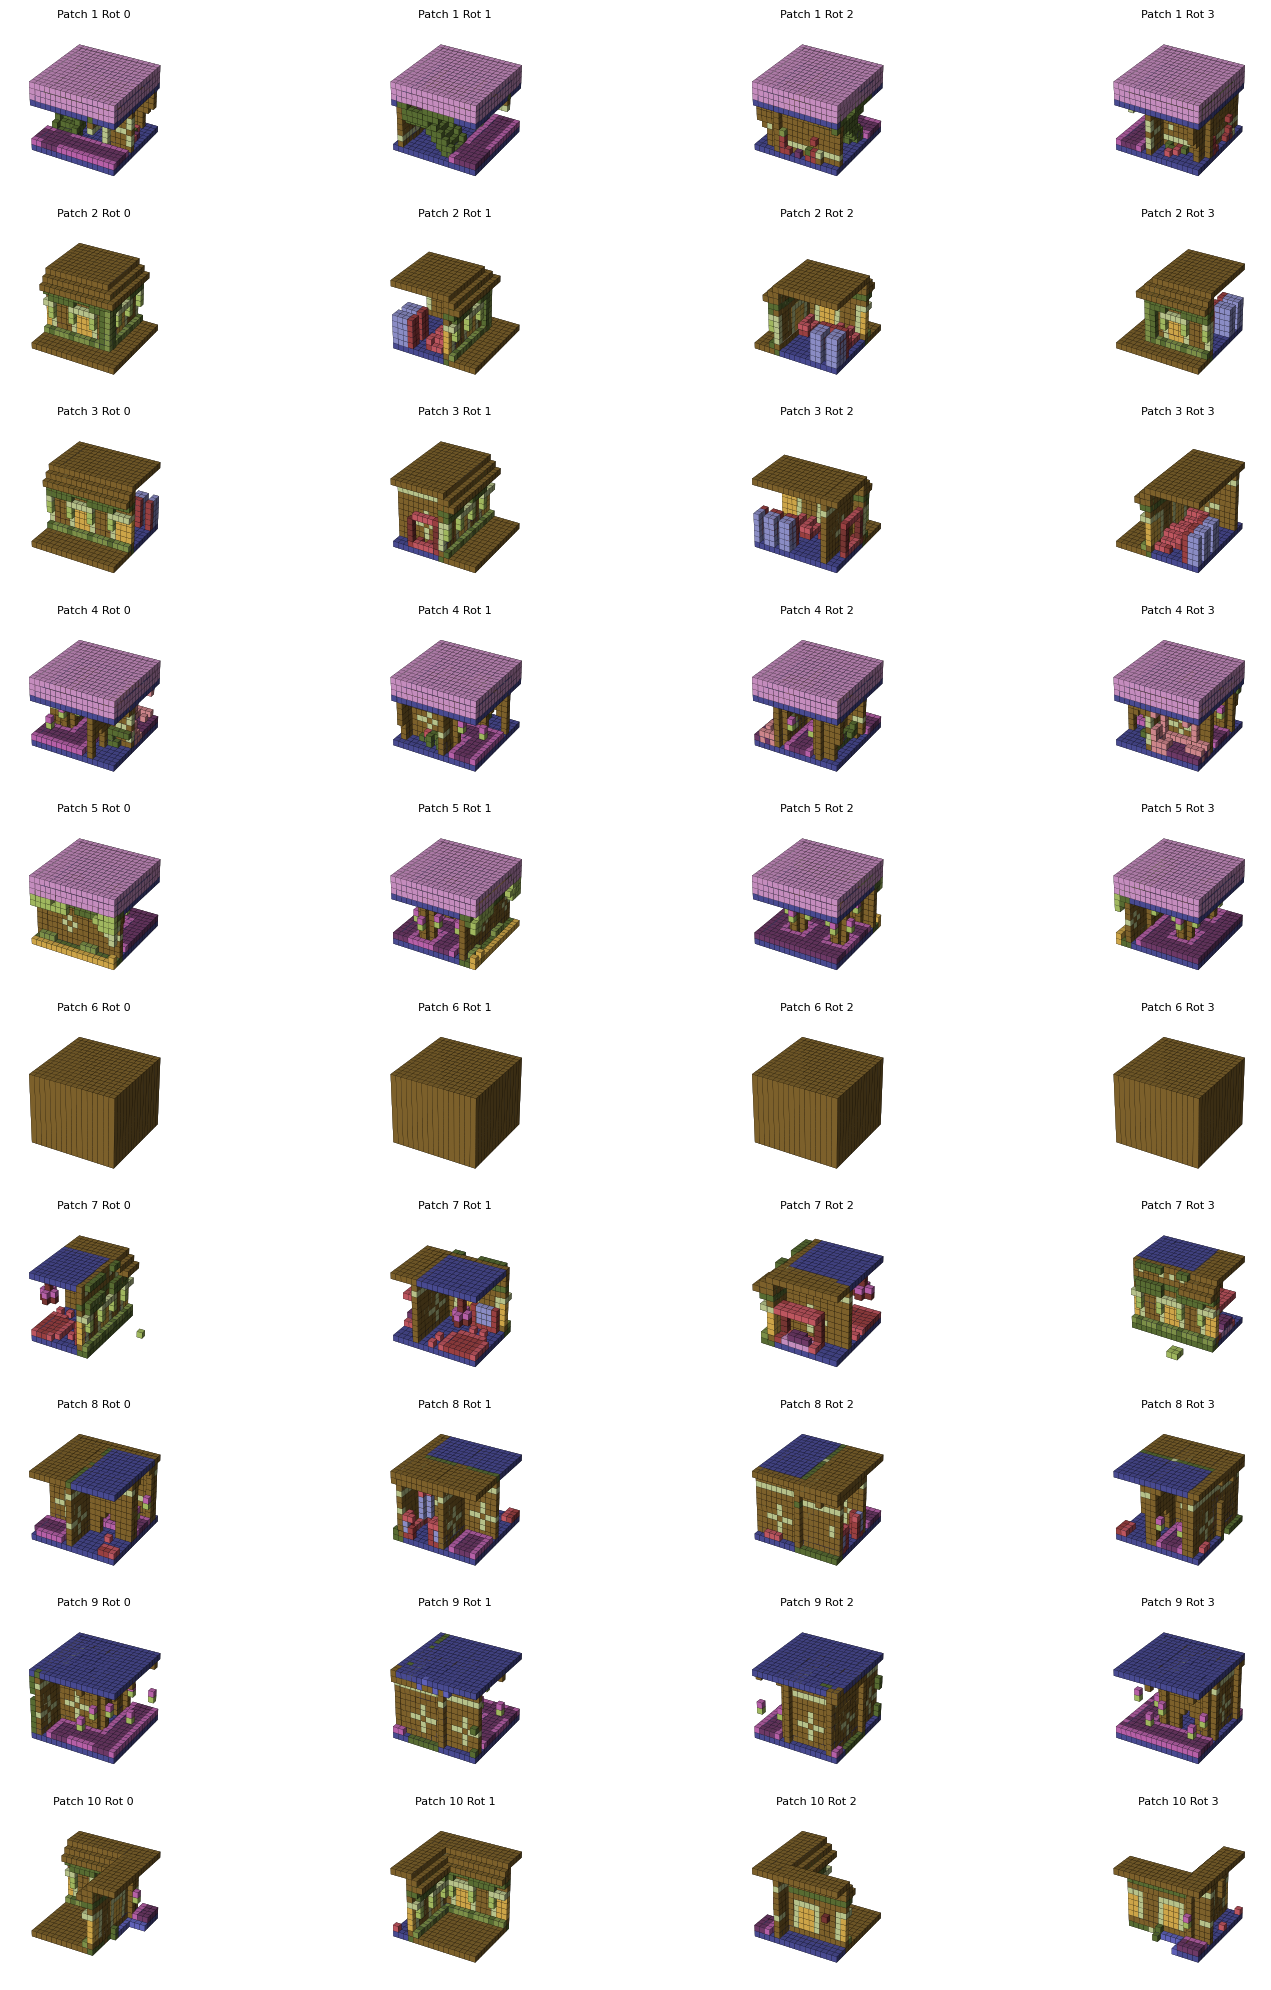

In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# 替换成你的导入方式

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoxelVAE().to(device)
model.load("voxelvae_64_434.pt")
model.eval()

# 可视化函数
def visualize_patch(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # x, z, y
    mask = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~mask] = [0, 0, 0, 0]
    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.1)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# 选取并显示修复后 latent 结果
latent_root = Path("latents")
all_paths = list(latent_root.rglob("*_rot0.pt"))
chosen = np.random.choice(all_paths, 10, replace=False)

fig = plt.figure(figsize=(16, 20))

with torch.no_grad():
    for i, base in enumerate(chosen):
        for k in range(4):
            path = str(base).replace("_rot0", f"_rot{k}")
            z = torch.load(path).to(device)

            # 自动判断 shape 是否是错误的 [64, 3, 4, 4]
            if z.shape == (64, 3, 4, 4):
                z = z.permute(0, 2, 1, 3).contiguous()  # → [64, 4, 3, 4]

            z = z.unsqueeze(0)  # [1, 64, 4, 3, 4]
            logits = model.decoder(z)
            pred_label = logits.argmax(dim=1).squeeze(0).cpu().numpy()

            ax = fig.add_subplot(10, 4, i * 4 + k + 1, projection='3d')
            visualize_patch(ax, pred_label, f"Patch {i+1} Rot {k}")

plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2189406302.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(path, map_location='cpu'),

📥 Loaded model from voxelvae_64_434.pt
📂 Patch: patch_x006_y008_z027.npy


C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2745499231.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20b", 31)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21476\2745499231.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowl

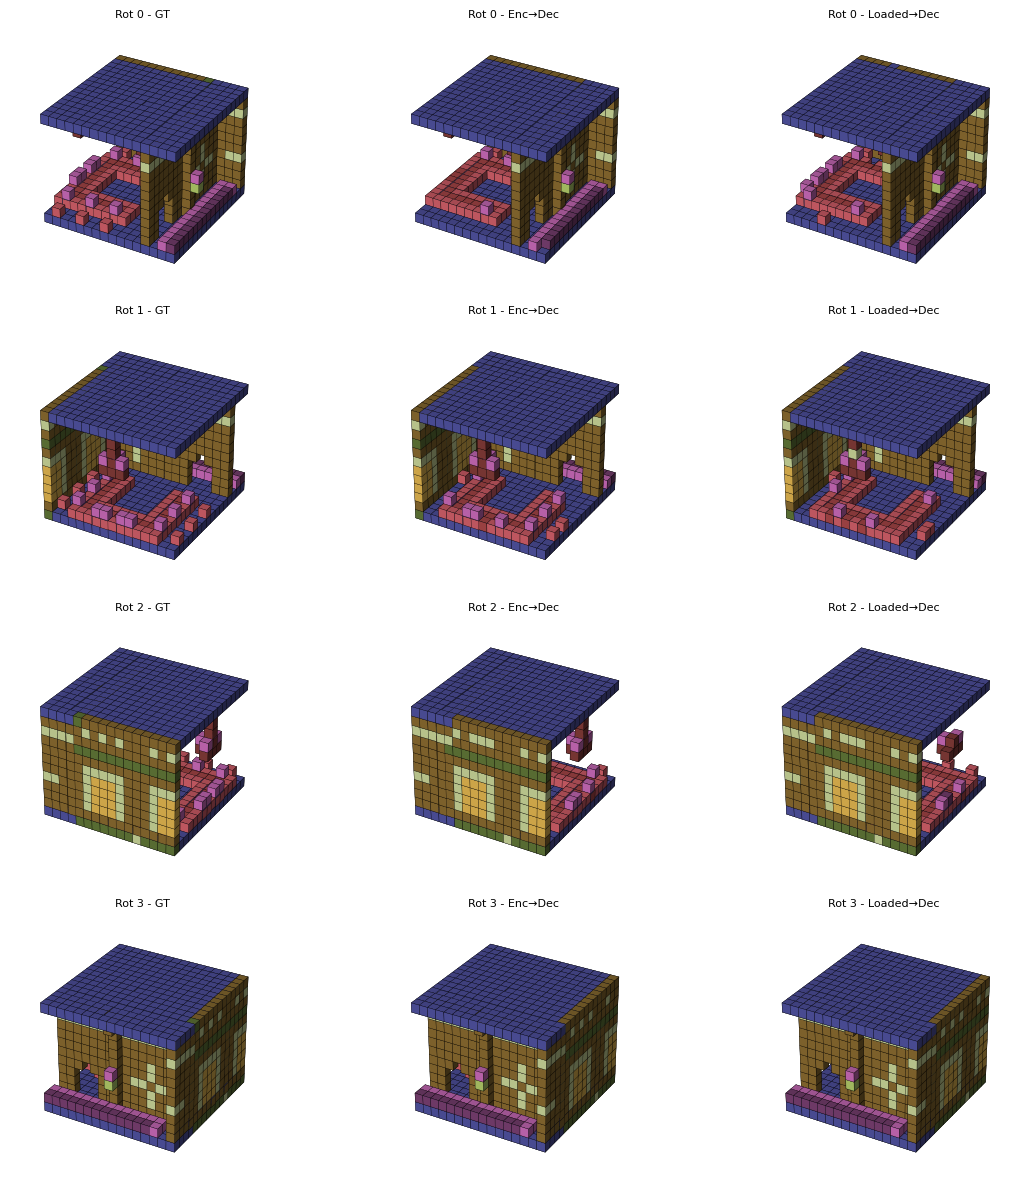

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VoxelVAE().to(device)
model.load("voxelvae_64_434.pt")
model.eval()

# === 可视化函数 ===
def visualize_patch(ax, label, title):
    cmap = plt.cm.get_cmap("tab20b", 31)
    label = np.transpose(label, (0, 2, 1))  # (X, Z, Y)
    mask = (label != 0)
    facecolors = cmap(label % 31)
    facecolors[~mask] = [0, 0, 0, 0]
    ax.voxels(mask, facecolors=facecolors, edgecolor='k', linewidth=0.2)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# === 随机选一个 patch ===
all_paths = list(Path("dataset").rglob("patch_*.npy"))
path = np.random.choice(all_paths)
print(f"📂 Patch: {path.name}")
voxel = np.load(path)

fig = plt.figure(figsize=(12, 12))

with torch.no_grad():
    for k in range(4):
        # === 原始 voxel（旋转）
        rotated = np.rot90(voxel, k=k, axes=(0, 2)).copy()
        ax1 = fig.add_subplot(4, 3, k * 3 + 1, projection='3d')
        visualize_patch(ax1, rotated, f"Rot {k} - GT")

        # === encoder → decoder
        input_tensor = torch.tensor(rotated, dtype=torch.long).unsqueeze(0).to(device)
        embed = model.embedding(input_tensor).permute(0, 4, 1, 2, 3)  # [B, C, H, W, D]
        z_enc, _, _ = model.encoder(embed)
        recon_logits = model.decoder(z_enc)
        recon_label = recon_logits.argmax(dim=1).squeeze(0).cpu().numpy()
        ax2 = fig.add_subplot(4, 3, k * 3 + 2, projection='3d')
        visualize_patch(ax2, recon_label, f"Rot {k} - Enc→Dec")

        # === .pt latent → decoder
        latent_path = Path("latents") / path.relative_to("dataset")
        latent_path = latent_path.with_name(latent_path.stem + f"_rot{k}.pt")
        if latent_path.exists():
            z_loaded = torch.load(latent_path).unsqueeze(0).to(device)
            logits_loaded = model.decoder(z_loaded)
            label_loaded = logits_loaded.argmax(dim=1).squeeze(0).cpu().numpy()
            ax3 = fig.add_subplot(4, 3, k * 3 + 3, projection='3d')
            visualize_patch(ax3, label_loaded, f"Rot {k} - Loaded→Dec")
        else:
            print(f"⚠️ {latent_path} not found!")

plt.tight_layout()
plt.show()
